In [235]:
import h5py
import network_predictions
import os
import matplotlib.pyplot as plt
import os
import paltas
from astropy.visualization import simple_norm
import visualization_utils
from paltas import generate
import numpy as np
import pandas as pd

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
os.getcwd()
path_to_weights = 'train_results/model_weights/_67-74043455212753045642280960.00_last.h5'
path_to_norms = 'generated_images/config_LSST/norms.csv'

In [12]:
trained = network_predictions.NetworkPredictions(path_to_model_weights=path_to_weights,
                                                 path_to_model_norms=path_to_norms,
                                                 learning_params=None,
                                                 loss_type='diag',
                                                 model_type='xresnet34',
                                                 norm_type='norm')

learning params ['main_deflector_parameters_theta_E', 'main_deflector_parameters_gamma1', 'main_deflector_parameters_gamma2', 'main_deflector_parameters_gamma', 'main_deflector_parameters_e1', 'main_deflector_parameters_e2', 'main_deflector_parameters_center_x', 'main_deflector_parameters_center_y']


In [85]:
# trained.model is gonna take all the inputs, do all the calculations and gives you output on your test object
# it is the trained nn
# precision is inverse of covariance matrix
from IPython.utils import io

with io.capture_output() as captured:

    y_test, y_pred, std_pred, prec_pred = trained.gen_network_predictions('generated_images/valid/config_LSST/',samples=False,shuffle=False);

0.3001008

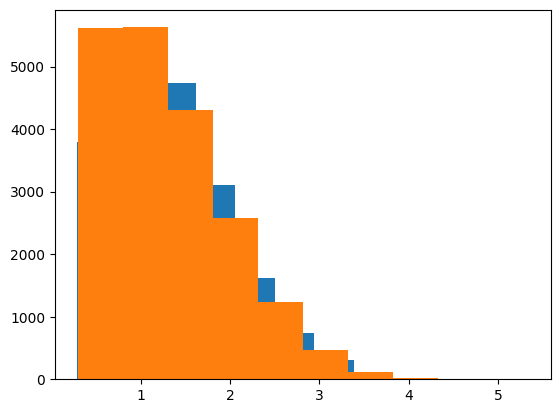

In [89]:
plt.hist(y_pred[:,0])
np.min(y_pred[:,0])
plt.hist(y_test[:,0])
np.min(y_test[:,0])

In [90]:
erad_std_pred = std_pred[:,0]
big = np.where(erad_std_pred>200000)
erad_std_pred[big]

print(big)

(array([ 2531,  4300,  8254,  9130, 17923, 18499, 19728]),)


In [76]:
import tensorflow as tf

In [154]:
ind = 2531
print(y_test[ind,:]), print(y_pred[ind,:]), 

[ 8.3052552e-01 -9.8176502e-02 -1.4958817e-01  2.4216933e+00
  1.2661843e-01  6.2855566e-03  4.1540857e-06 -2.9992921e-07]
[ 5.6729585e-01  1.9892681e+00 -1.0770916e+00 -1.3105087e+00
  1.9829628e+00 -3.4809753e-01 -1.0249178e-04 -3.1155560e-04]


(None, None)

In [159]:
import pandas as pd

df = pd.read_csv('generated_images/valid/config_LSST/metadata.csv')
theta_E = df['main_deflector_parameters_theta_E'].to_numpy()
len_mag = df['lens_light_parameters_mag_app'].to_numpy()
ps_mag = df['point_source_parameters_mag_app'].to_numpy()

image 2531 min after normalization: 0.00038541903976889647;
theta_E_test:0.8305255174636841;
theta_E_pred:0.5672958493232727
theta_E_err:76942843904.0
1/1 [==============================] - 0s 18ms/step
theta_E_test:0.8305255174636841;
theta_E_pred:0.5672958493232727: theta_E_pred1:0.5673229098320007
theta_E_err:76942843904.0: theta_E_std_pred1:76942114816.0
image 4300 min after normalization: 0.00010540476050982322;
theta_E_test:1.6044303178787231;
theta_E_pred:0.9063857793807983
theta_E_err:448187.875
1/1 [==============================] - 0s 30ms/step
theta_E_test:1.6044303178787231;
theta_E_pred:0.9063857793807983: theta_E_pred1:0.906388521194458
theta_E_err:448187.875: theta_E_std_pred1:448189.5625
image 8254 min after normalization: -0.0019336998744448658;
theta_E_test:0.307043194770813;
theta_E_pred:0.8527512550354004
theta_E_err:653826.9375
1/1 [==============================] - 0s 19ms/step
theta_E_test:0.307043194770813;
theta_E_pred:0.8527512550354004: theta_E_pred1:0.852750

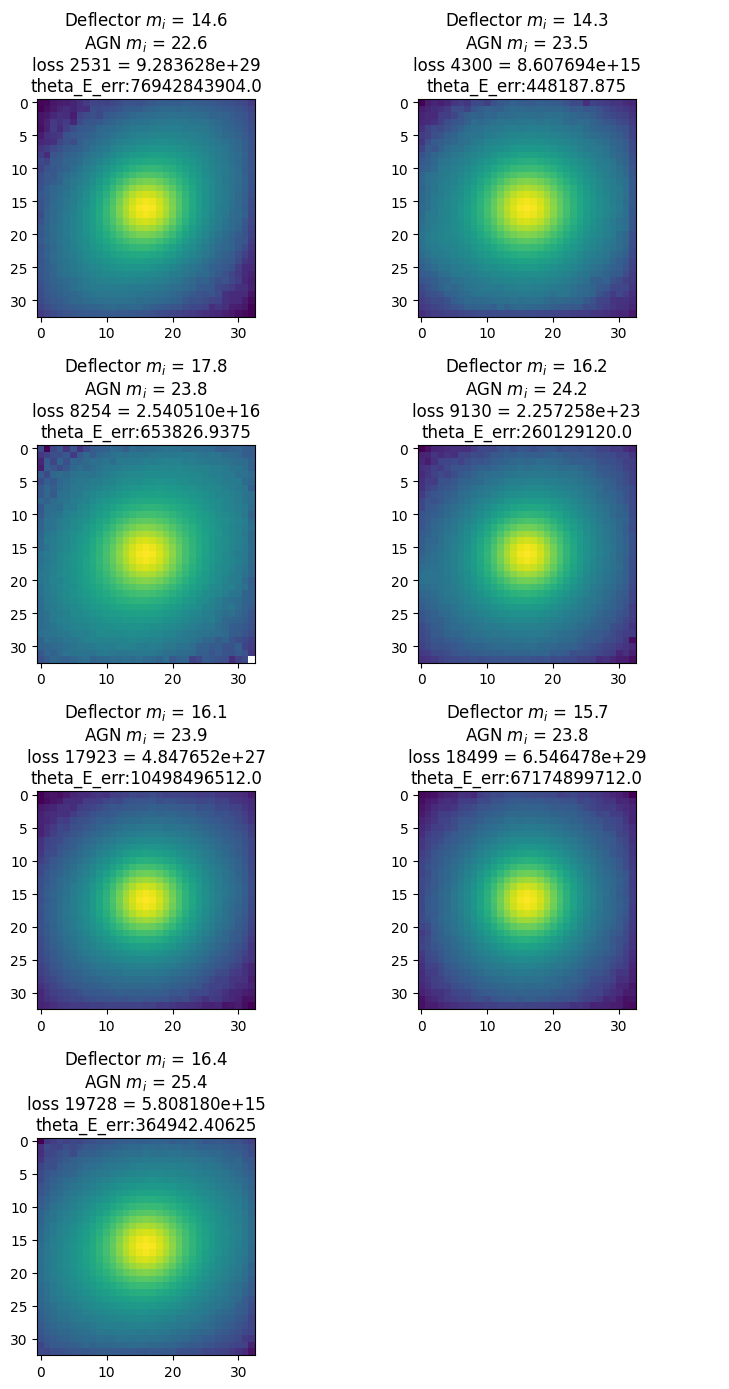

In [186]:
prob_idx = [ 2531,  4300,  8254,  9130, 17923, 18499, 19728]
fig, ax = plt.subplots(4, 2, figsize=(8,14))
ax = ax.flatten()
for i in range(len(prob_idx)):
    img = np.load('generated_images/valid/config_LSST/image_%07d.npy'%(prob_idx[i]))
    ax[i].imshow(img,norm='log')
    

    from paltas.Analysis.dataset_generation import norm_image, unnormalize_outputs

    #print(f'image {prob_idx[i]} min before normalization: {np.min(img)}')

    img_normed = norm_image(img)
    print(f'image {prob_idx[i]} min after normalization: {np.min(img_normed)};\ntheta_E_test:{y_test[prob_idx[i],0]};\ntheta_E_pred:{y_pred[prob_idx[i],0]}\ntheta_E_err:{std_pred[prob_idx[i],0]}')
    img_batch = tf.reshape(img_normed,[1,33,33,1])
    ax[i].set_title(f'Deflector $m_i$ = {np.round(len_mag[prob_idx[i]],1)}\nAGN $m_i$ = {np.round(ps_mag[prob_idx[i]],1)}'+
                    f'\nloss {prob_idx[i]} = {trained.loss_single_image(y_test[prob_idx[i],:],img_batch):e}'+
                    f'\ntheta_E_err:{std_pred[prob_idx[i],0]}')
    

    y_pred1,std_pred1,cov_mat1 = trained._process_image_batch(img_batch,norm_path=path_to_norms)
    y_pred1 = y_pred1.numpy()
    unnormalize_outputs(path_to_norms,trained.learning_params+[],
                y_pred1,standard_dev=std_pred1)
    print(f'theta_E_test:{y_test[prob_idx[i],0]};\ntheta_E_pred:{y_pred[prob_idx[i],0]}: theta_E_pred1:{y_pred1[0][0]}\ntheta_E_err:{std_pred[prob_idx[i],0]}: theta_E_std_pred1:{std_pred1[0][0]}')

plt.axis('off')
fig.tight_layout()

In [206]:
normed_image = img_normed.numpy()
unnormed_image = img

In [217]:
import matplotlib
scales = matplotlib.scale.get_scale_names()
scales = ['asinh', 'linear', 'log', 'logit', 'symlog']

asinh
linear
log
logit
symlog


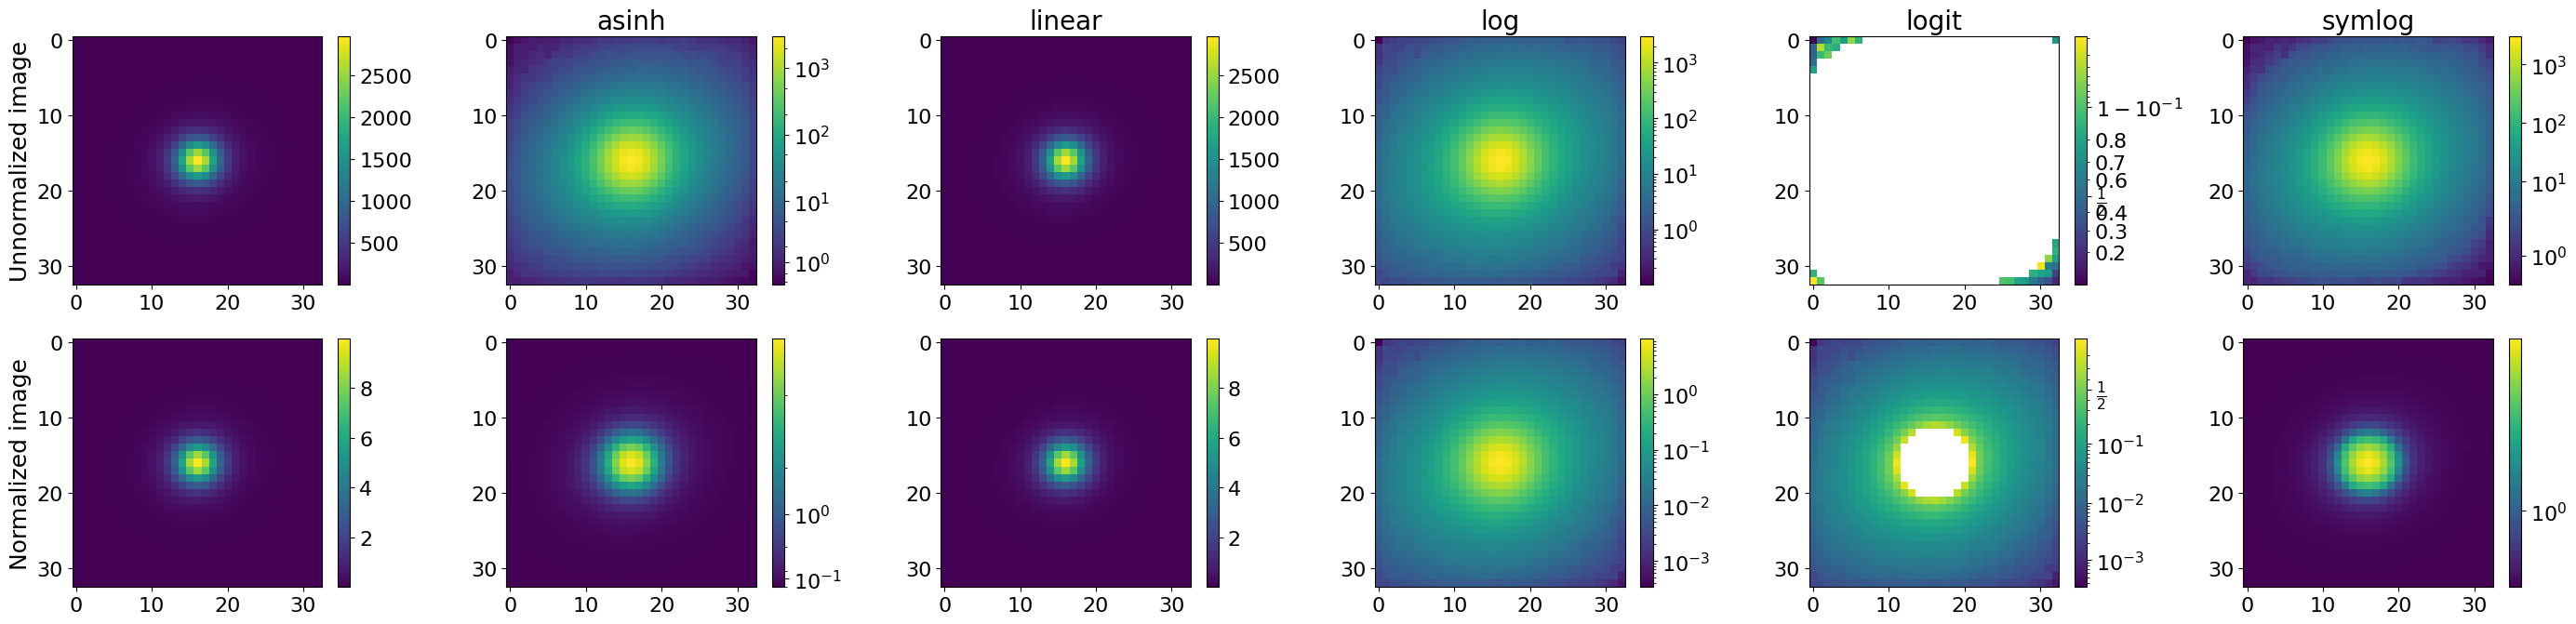

In [238]:
fig, ax = plt.subplots(2, 6,figsize=(28, 7))
im_asinh_unnorm = plt.imshow(unnormed_image, norm='asinh');
uzim = ax[0][0].imshow(unnormed_image, aspect='auto')
ax[0][0].set_ylabel('Unnormalized image')
fig.colorbar(uzim)
nzim = ax[1][0].imshow(normed_image, aspect='auto')
ax[1][0].set_ylabel('Normalized image')
fig.colorbar(nzim)

for sc in range(1, len(scales)+1):
    norm = scales[sc-1]
    print(norm)
    uim = ax[0][sc].imshow(unnormed_image, norm=norm, aspect='auto')
    nim = ax[1][sc].imshow(normed_image, norm=norm, aspect='auto')
    ax[0][sc].set_title(norm)

    fig.colorbar(uim)

    fig.colorbar(nim)

fig.tight_layout()

In [239]:
import astropy.visualization as asviz

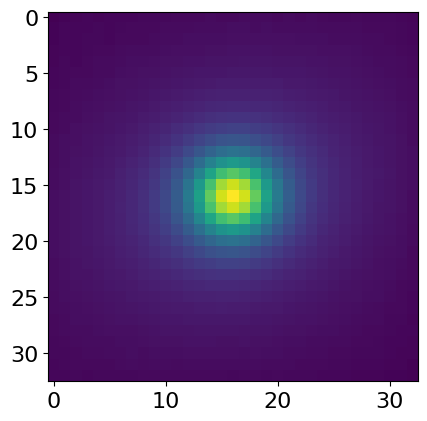

In [249]:
testnorm = asviz.simple_norm(normed_image, stretch='power', power=0.5
                             ,asinh_a=0.1, 
                             min_cut=None, 
                             max_cut=None, 
                             min_percent=None, 
                             max_percent=None, 
                             percent=None, 
                             clip=False, log_a=1000, invalid=-1.0, sinh_a=0.3)

plt.imshow(normed_image, norm=testnorm)

## I THINK THE PROBLEM IS THE LENS LIGHT IS WAY TOO BRIGHT IN ALL OF THESE EXAMPLES - SYDNEY ##

In [152]:
df

,cosmology_parameters_cosmology_name,detector_parameters_background_noise,detector_parameters_ccd_gain,detector_parameters_exposure_time,detector_parameters_magnitude_zero_point,detector_parameters_num_exposures,detector_parameters_pixel_scale,detector_parameters_read_noise,detector_parameters_sky_brightness,lens_light_parameters_R_sersic,...,seed,source_parameters_R_sersic,source_parameters_center_x,source_parameters_center_y,source_parameters_e1,source_parameters_e2,source_parameters_mag_app,source_parameters_n_sersic,source_parameters_output_ab_zeropoint,source_parameters_z_source
0,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,0.983459,...,3759640345,0.310517,0.151820,-0.133445,-0.058047,-0.012972,22.518898,3.999259,27.79,1.905381
1,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,1.609183,...,[3759640346],0.662579,0.647236,-0.903203,0.072203,-0.031077,22.011372,3.998642,27.79,1.875828
2,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,0.900564,...,[3759640347],3.460373,0.346917,0.437548,-0.090750,-0.023869,22.676813,3.999669,27.79,3.131662
3,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,1.123533,...,[3759640348],1.052143,0.006172,-0.877032,0.110201,-0.026829,25.267727,3.999928,27.79,2.511861
4,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,0.832587,...,[3759640349],1.689184,0.663739,-0.619637,0.011941,0.046240,26.200744,4.000279,27.79,1.692886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,0.615136,...,[3759660340],0.279657,-0.294007,-0.540109,-0.002467,-0.209774,24.080685,4.000554,27.79,3.101464
19996,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,1.972476,...,[3759660341],1.699949,0.243941,0.250646,0.002651,-0.001773,21.574103,4.000417,27.79,3.392115
19997,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,1.338234,...,[3759660342],0.248092,0.587930,0.777069,0.129339,0.033422,23.127131,3.998958,27.79,2.948109
19998,planck18,NaN,2.3,15,27.79,150,0.2,10,20.48,2.124930,...,[3759660343],1.227182,-0.016397,0.818317,0.045798,-0.028421,27.008785,3.999738,27.79,3.019934


In [143]:


print(theta_E[prob_idx[i]])
print(len_mag[prob_idx[i]])
print(ps_mag[prob_idx[i]])

0.6458273286989646
15.715834882911793
23.77401941289228


In [124]:
print(y_test[prob_idx[i],:])
print(y_pred[prob_idx[i],:])
print(std_pred[prob_idx[i],:])

[ 2.3496208e+00  2.6157899e-02  1.1001923e-02  1.6908579e+00
 -1.5326442e-01 -6.0490619e-02 -3.1274047e-07 -1.6768334e-05]
[ 7.6444983e-01  1.5331528e+00 -8.3366942e-01 -5.0925207e-01
  1.5276768e+00 -2.6573768e-01 -7.8813682e-05 -2.3904472e-04]
[2.6012912e+08 9.9024178e-11 6.9997982e-06 6.4274808e-08 2.2967563e-12
 2.5035918e-06 3.0639430e-07 8.7037133e-06]


In [114]:
print(y_pred1)

[[ 7.6446199e-01  1.5331526e+00 -8.3366901e-01 -5.0925112e-01
   1.5276761e+00 -2.6573810e-01 -7.8813653e-05 -2.3904466e-04]]


In [115]:
print(std_pred1)

[[2.6012712e+08 9.9024365e-11 6.9997845e-06 6.4274992e-08 2.2967695e-12
  2.5035963e-06 3.0639444e-07 8.7037206e-06]]


0.3001008

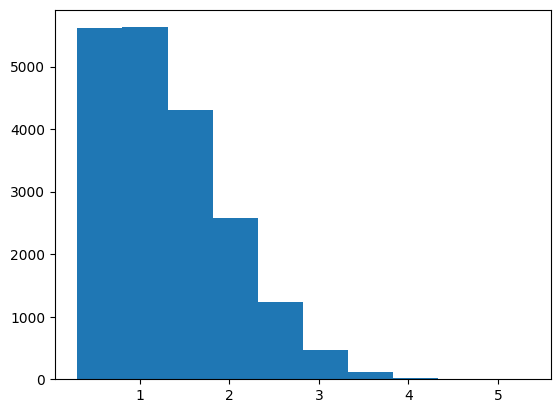

In [84]:


plt.figure()

In [82]:
print(y_pred)
print(std_pred)

tf.Tensor(
[[ -1.0593952  19.890312  -10.783186  -14.878182   19.839659   -3.4730072
  -10.243216  -31.171808 ]], shape=(1, 8), dtype=float32)
[ 8.3052552e-01 -9.8176502e-02 -1.4958817e-01  2.4216933e+00
  1.2661843e-01  6.2855566e-03  4.1540857e-06 -2.9992921e-07]
[[1.1001489e+11 1.7228916e-12 3.6876929e-06 2.4400080e-09 1.4467567e-14
  9.7395775e-07 1.0089114e-02 8.9296961e-01]]


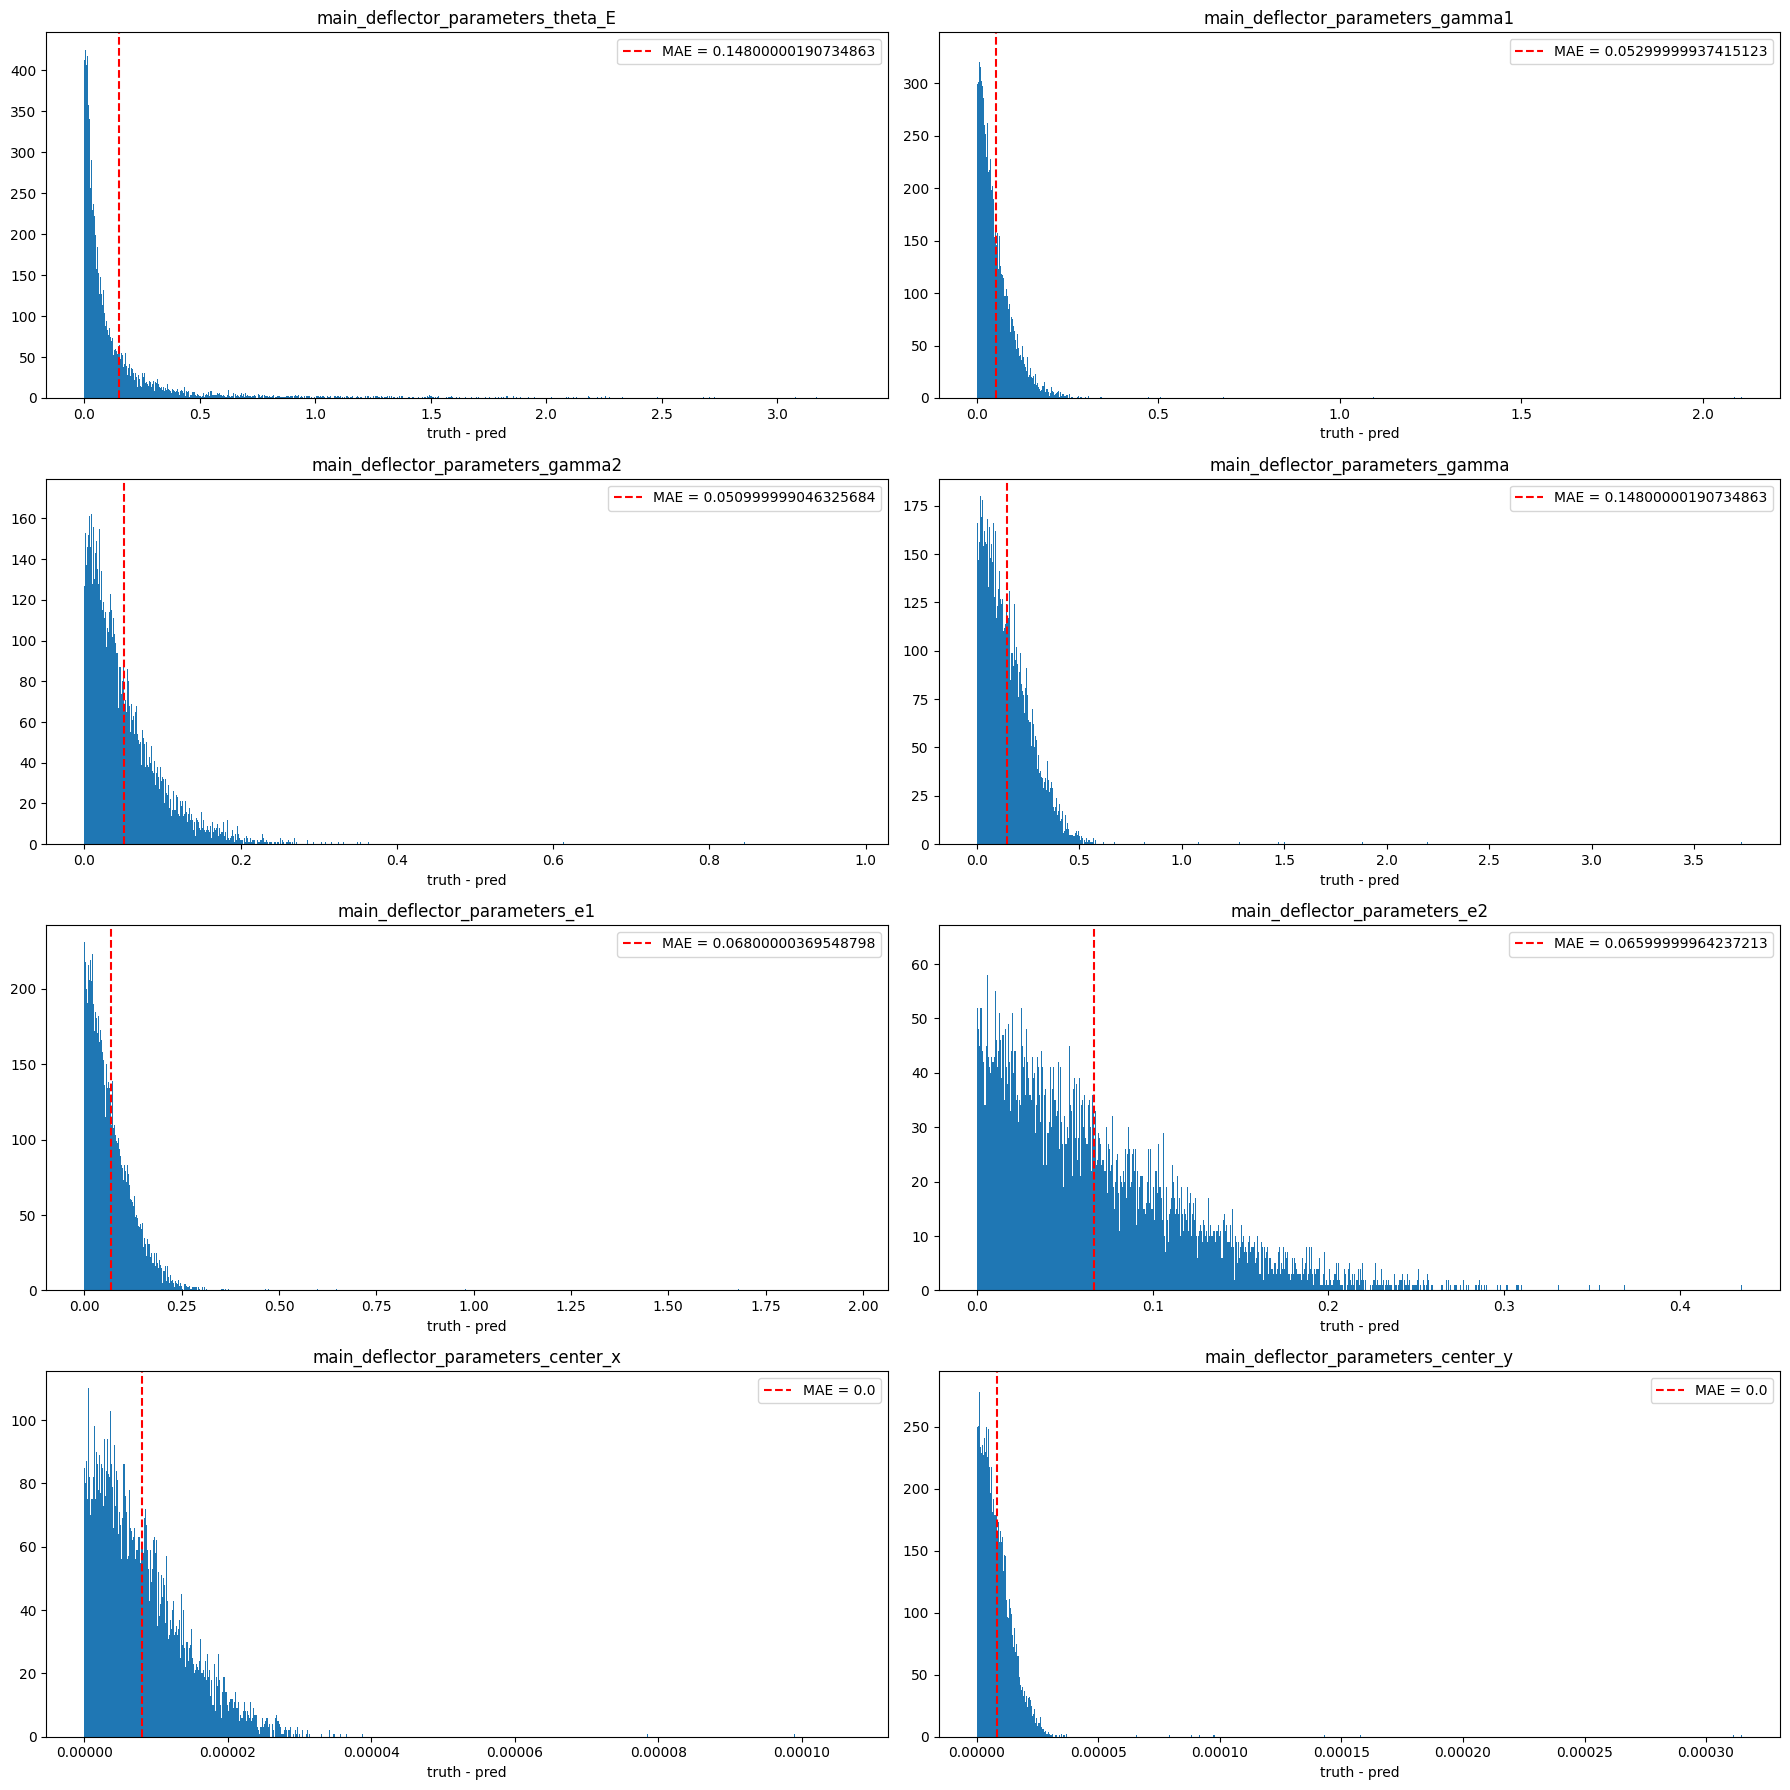

In [63]:
fig, ax = plt.subplots(4, 2, figsize=(18, 18))
ax = ax.flatten()
for i in range(y_pred.shape[1]):
    mae = np.abs(y_test[:, i] - y_pred[:, i])
    ax[i].hist(mae, bins=2000)
    redline =np.mean(mae)
    rounded = np.round(redline, 3)
    ax[i].axvline(redline,ls='--', color='r', label=f'MAE = {rounded}')
    ax[i].set_title(trained.learning_params[i])
    ax[i].set_xlabel('truth - pred')
    ax[i].legend()
fig.tight_layout()

/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_66467/727992644.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(y_test[:,i], y_pred[:,i],yerr=std_pred[:,i], fmt='o', marker='s', ms=2)


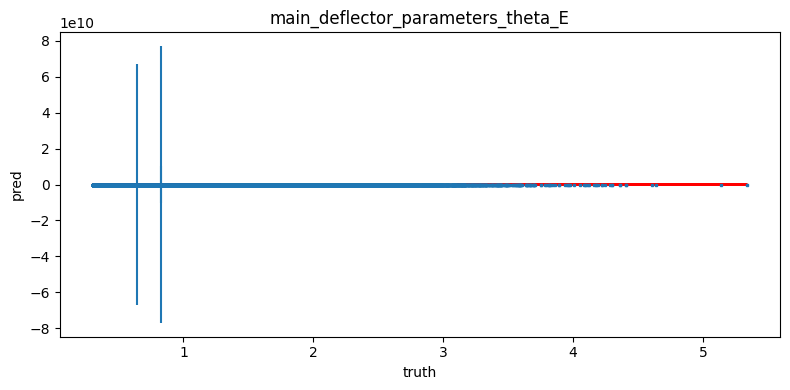

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for i in range(1):
    
    ax.errorbar(y_test[:,i], y_pred[:,i],yerr=std_pred[:,i], fmt='o', marker='s', ms=2)
    ax.plot(y_test[:,i], y_test[:,i], color='r')
    ax.set_title(trained.learning_params[i])
    ax.set_xlabel('truth')
    ax.set_ylabel('pred')
fig.tight_layout()

/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_66467/3601586887.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax[i].errorbar(y_test[:,i], y_pred[:,i],yerr=std_pred[:,i], fmt='o', marker='s', ms=2)


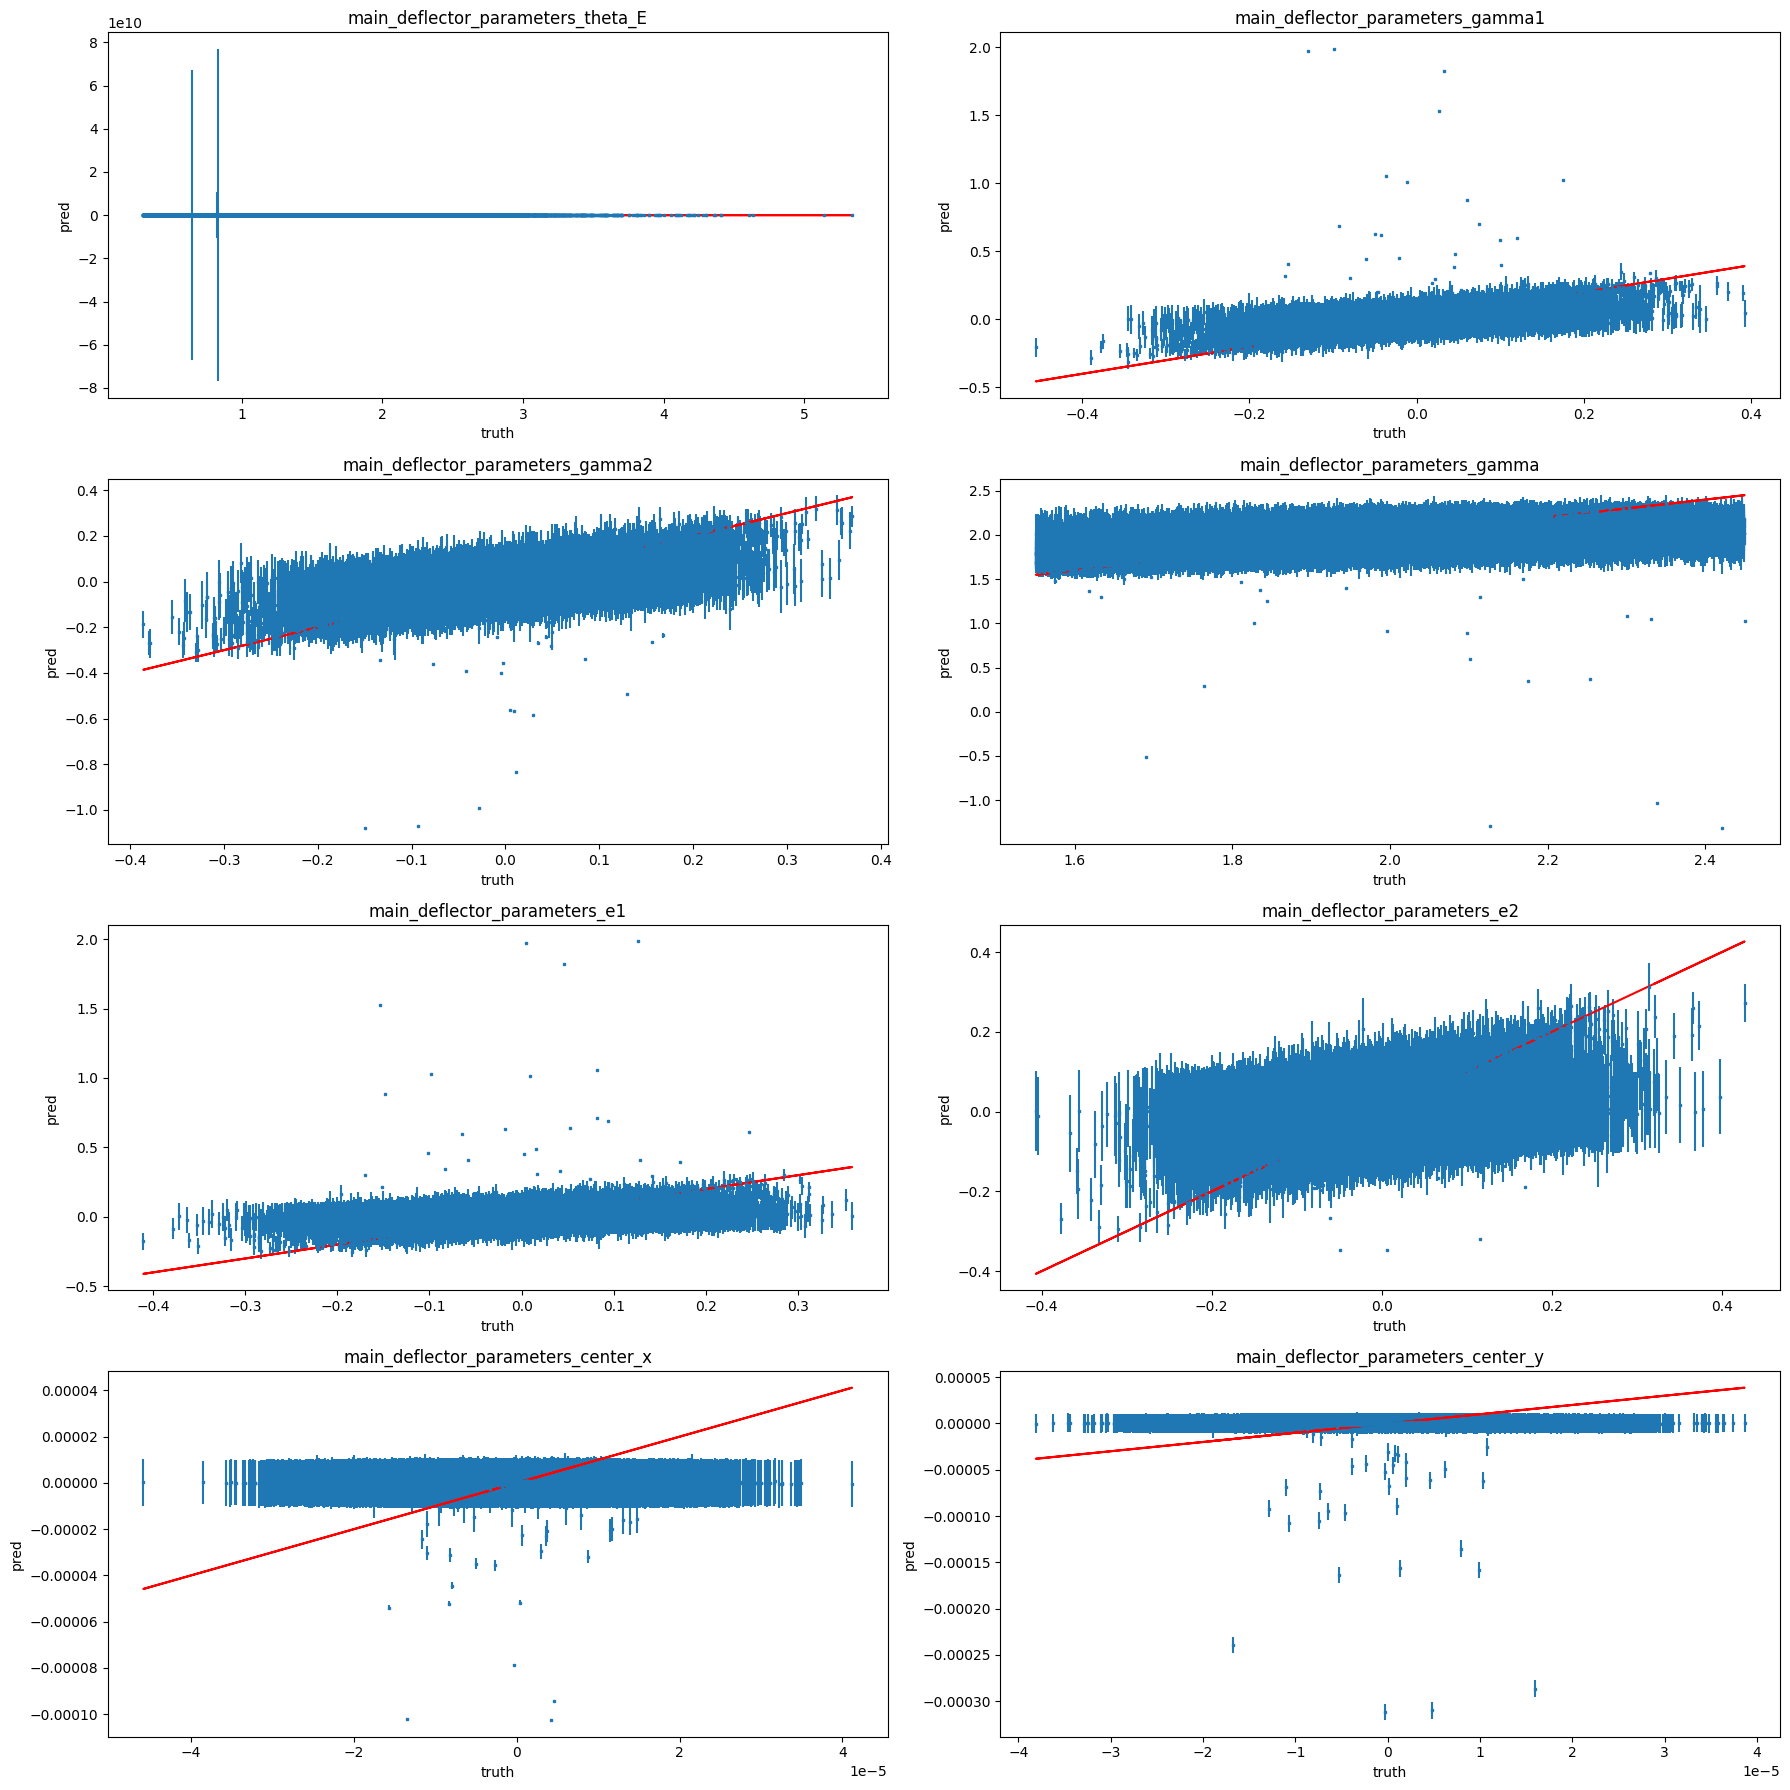

In [147]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 2, figsize=(18, 18))
ax = ax.flatten()
for i in range(y_pred.shape[1]):
    
    ax[i].errorbar(y_test[:,i], y_pred[:,i],yerr=std_pred[:,i], fmt='o', marker='s', ms=2)
    ax[i].plot(y_test[:,i], y_test[:,i], color='r')
    ax[i].set_title(trained.learning_params[i])
    ax[i].set_xlabel('truth')
    ax[i].set_ylabel('pred')
fig.tight_layout()

In [35]:
filename = "train_results/model_weights/_04-2.26_best.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])
    it = f[a_group_key].items()
    for k, v in it:
        print(k,v)

    # # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    # ds_arr = f[a_group_key][()]  # returns as a numpy array

Keys: <KeysViewHDF5 ['model_weights', 'optimizer_weights']>
<class 'h5py._hl.group.Group'>
avg_pool <HDF5 group "/model_weights/avg_pool" (0 members)>
input_1 <HDF5 group "/model_weights/input_1" (0 members)>
output_dense <HDF5 group "/model_weights/output_dense" (1 members)>
stack1_block1_add <HDF5 group "/model_weights/stack1_block1_add" (0 members)>
stack1_block1_bn1 <HDF5 group "/model_weights/stack1_block1_bn1" (1 members)>
stack1_block1_bn2 <HDF5 group "/model_weights/stack1_block1_bn2" (1 members)>
stack1_block1_conv1 <HDF5 group "/model_weights/stack1_block1_conv1" (1 members)>
stack1_block1_conv2 <HDF5 group "/model_weights/stack1_block1_conv2" (1 members)>
stack1_block1_out <HDF5 group "/model_weights/stack1_block1_out" (0 members)>
stack1_block1_pad1 <HDF5 group "/model_weights/stack1_block1_pad1" (0 members)>
stack1_block1_pad2 <HDF5 group "/model_weights/stack1_block1_pad2" (0 members)>
stack1_block1_relu1 <HDF5 group "/model_weights/stack1_block1_relu1" (0 members)>
stack

ValueError: Invalid group (or file) id (invalid group (or file) ID)

In [22]:
def read_hdf5(path):

    weights = {}

    keys = []
    with h5py.File(path, 'r') as f: # open file
        f.visit(keys.append) # append all keys to list
        for key in keys:
            if ':' in key: # contains data if ':' in key
                print(f[key].name)
                weights[f[key].name] = f[key].value
    return weights

In [23]:
read_hdf5(filename)

/model_weights/output_dense/output_dense/bias:0


AttributeError: 'Dataset' object has no attribute 'value'

In [24]:
%h5dump -H -A 0 "train_results/model_weights/_04-2.26_best.h5"


UsageError: Line magic function `%h5dump` not found.
